# Task 8 


Text data analysis is becoming easier and easier every day. Prominent programming languages like Python and R have great libraries for text data analysis. There was a time when people used to think that you need to be an expert in coding to do these types of complex tasks. But with the more developed and improved version of libraries, it is easier to perform text data analysis with just simple and beginner-level coding knowledge.
In this Notebook, I will work on a dataset that is primarily a text dataset. The dataset contains the Stack exchange website data, including comments, posts, tags and history. This data can be downloaded from internet. This is a great dataset to use for machine learning as it has posts with their number of views. But in this notebook I will only be using data extraction and visulization techniques to explore the dataset.

First i need some predefined libraries which I will use in the following tasks. I need pandas which is a basic library to deal with the dataframes, otherone is csv which I need to use to convert xml data into a csv file data. I need to convert xml data to csv data due to which `xml.etree.ElementTree` is reuqired. I will also be using some visualization libraries like seaborn and matplotlib which are famour visualization libraires in python programming. Furthermore, I am also adding some basic libraries that are used while analyzing textual data. 

In [2]:
import pandas as pd
import csv 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from textblob import TextBlob, Word, Blobber
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer

To convert a xml file into a csv file I am making a user defined function named xml_to_csv which takes 2 arguments including path of the xml file and the name of csv file in which converted file is to be stored. Here I will parse the xml file data usign `ET.parse(file)` which will parse the data and store in a variable tree. To get the root of tree I am uisng `tree.getroot()` which gives me the tree root. Now using these tree and their root I will get the header and each row of the data and them storing that data into a csv file. 

In [3]:
def xml_to_csv(file_path, csv_name):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    with open(csv_name, 'w') as csv_file:
        writer = csv.writer(csv_file)
        headers = (child.tag for child in root[0])
        writer.writerow(headers)
        num_records = len(root)
        
        for record in range(num_records):
            rec = (child.text for child in root[record])
            writer.writerow(rec)
            

Now to create the csv files, I am calling above defined function which will be feed with each to the different dataset and I will give a csv file which will be generated from the function. 

In [7]:
xml_to_csv('/kaggle/input/stack-exchange-data/Badges.xml','Badges.csv')
xml_to_csv('/kaggle/input/stack-exchange-data/Comments.xml','comments.csv')
xml_to_csv('/kaggle/input/stack-exchange-data/PostHistory.xml','PostHistory.csv')
xml_to_csv('/kaggle/input/stack-exchange-data/PostLinks.xml','PostLinks.csv')
xml_to_csv('/kaggle/input/stack-exchange-data/Posts.xml','Posts.csv')
xml_to_csv('/kaggle/input/stack-exchange-data/Tags.xml','Tags.csv')
xml_to_csv('/kaggle/input/stack-exchange-data/Users.xml','Users.csv')
xml_to_csv('/kaggle/input/stack-exchange-data/Votes.xml','Votes.csv')

Here now that I got the csv files for each of the dataset, now I am reading these csv files using `pd.read_csv()` to create a pandas dataframe which can easily be used to interact with the textual data. 

In [6]:
Badges = pd.read_csv('/kaggle/working/Badges.csv')
Comments = pd.read_csv('/kaggle/working/Comments.csv')
PostHistory = pd.read_csv('/kaggle/working/PostHistory.csv')
PostLinks =pd.read_csv('/kaggle/working/PostLinks.csv')
Posts =pd.read_csv('/kaggle/working/Posts.csv')
Tags = pd.read_csv('/kaggle/working/Tags.csv')
Users=  pd.read_csv('/kaggle/working/Users.csv')
Votes = pd.read_csv('/kaggle/working/Votes.csv')

I found that data contains alot of NaN values which would always remain problametic in the upcomming analysis, so I am removing all the null values and replacing them with 0.

In [7]:
Badges.fillna(0,inplace=True)
Comments.fillna(0,inplace=True)
PostHistory.fillna(0,inplace=True)
PostLinks.fillna(0,inplace=True)
Posts.fillna(0,inplace=True)
Tags.fillna(0,inplace=True)
Users.fillna(0,inplace=True)
Votes.fillna(0,inplace=True)

#### Comments
Here I take comments dataset to explor it and find some meaning full extraction from the dataset. This dataset contains the comments, their text, id, and other details. I will be mostly working with Text column as it is a textual data so I will select that column and see what I find in it.
Text comments may contain a lot of special characters that are not helpful for any analysis. It’s good to clean them in the beginning.

Text comments may contain a lot of special characters that are not helpful for any analysis. It’s good to clean them in the beginning. In this block of code I am using `str.replace` to remove all the unwanted special characters. 

In [8]:

warnings.simplefilter(action='ignore', category=FutureWarning)
def clean(txt):
    txt = txt.str.replace("()", "")
    txt = txt.str.replace('(<a).*(>).*()', '')
    txt = txt.str.replace('(&amp)', '')
    txt = txt.str.replace('(&gt)', '')
    txt = txt.str.replace('(&lt)', '')
    txt = txt.str.replace('(\xa0)', ' ')  
    return txt
Comments['Text'] = clean(Comments['Text'])

In [9]:
Posts['Body'] = clean(Posts['Body'])

This textual data would likely have mixed word in upper and lower case. So converting to lower case is necessary. Otherwise, it will consider the same word with an uppercase as a different word. Like ‘me’ and ‘Me’ will be considered as different words. We don’t want that.

In [10]:
Comments['Text1'] = Comments['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
Comments['Text1'].head()

0    i am in the same position. i know very little,...
1    sorry, i implied that it should only be mandat...
2    if printer tags would be mandatory, i also thi...
3    @ericjohnson true, i guess i over-thought this...
4    agree. i think at this stage of development, 3...
Name: Text1, dtype: object

In [11]:
Posts['Body1'] = Posts['Body'].apply(lambda x: " ".join(x.lower() for x in x.split()))

Now that we have converted words into lowercase, next step is to deal with stopwords. Stopwords are some grammatical or binding words like ‘is’, ‘the’, ‘and’, ‘so’, ‘my’ etc. These are the words that appear very frequently. But may not add any value to the analysis. Although it is arguable. Some people think they are important at times. In some artificial intelligence projects, they may be important but for this example, I am just removing these stopwords to make the analysis a bit easier.

To complete this part I will use nltk library from which I can download all the stop words and then by comparing comments textual data with these stopwords I will be removing them.

In [12]:
warnings.simplefilter(action='ignore')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
Comments['Text1'] = Comments['Text1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
Comments['Text1'].head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    position. know little, interested, want contri...
1    sorry, implied mandatory questions applicable ...
2    printer tags would mandatory, also think slice...
3    @ericjohnson true, guess over-thought this, qu...
4    agree. think stage development, 3d printing ex...
Name: Text1, dtype: object

In [13]:
Posts['Body1'] = Posts['Body1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

There are some words that appeared only once. Those rare words do not add anything to it. So we can safely discard them. First, find the frequency of each word and then find out the words that appeared only once. This is just a simple addition to make the analysis clean and simple. 

To complete this task I am counting the number or words occurence to find the frequency and then based on that frequency I will be removing the words that are least frequent.

In [14]:
freq = pd.Series(' '.join(Comments['Text1']).split()).value_counts()
less_freq = list(freq[freq ==1].index)

In [15]:
Comments['Text1'] = Comments['Text1'].apply(lambda x: " ".join(x for x in x.split() if x not in less_freq))

While textual data analysis it is important to deal with the spelling mistakes as these words can get different meaning of complete sentence. Simple spelling mistakes can be corrected using the correct() function available in TextBlob module of python. 

In [16]:
Comments['Text1'].apply(lambda x: str(TextBlob(x).correct()))
Comments['Text1'].head()

0          know want questions, well, would contribute
1    sorry, mandatory questions applicable mandator...
2       printer tags would also think slicer tags well
3    @ericjohnson true, guess this, questions gener...
4    agree. think stage 3d printing experts necessa...
Name: Text1, dtype: object

Just to make the data exploration steps complete, the next step is lemmatization to bring the words in their root form. You can choose either stemming or lemmatization. After stemming, you may not see many changes in the lemmatization. I am still showing it for demonstration purposes.

In [17]:

warnings.simplefilter(action='ignore')
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

Lemmatization can be done by a function lemmatize() that is available in textblob module `TextBlob.Word()`

In [18]:
Comments['Text1'] = Comments['Text1'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
Comments['Text1'].head()

0          know want questions, well, would contribute
1    sorry, mandatory question applicable mandatory...
2         printer tag would also think slicer tag well
3    @ericjohnson true, guess this, question generally
4    agree. think stage 3d printing expert necessar...
Name: Text1, dtype: object

At the end I am checking is the punctuation are available if so it is required to remove the punctuation marks. This step is to remove the punctuations. Because of punctuation, a word might be treated differently than it originally is. For example ‘use’ and ‘use:’ will become different words because of punctuation.

In [19]:
Comments['Text1'] = Comments['Text1'].str.replace('[^\w\s]', '')
Comments['Text1'].head()

0            know want questions well would contribute
1    sorry mandatory question applicable mandatory ...
2         printer tag would also think slicer tag well
3       ericjohnson true guess this question generally
4    agree think stage 3d printing expert necessari...
Name: Text1, dtype: object

In [20]:
Posts['Body1'] = Posts['Body1'].str.replace('[^\w\s]', '')

###### Comments data analysis
Table1

In this I am making a simple calculation to make a meaning full table that gives information about the comments available in comments data.
Let’s start the analysis by adding some more features to the dataset. Here, I am adding the length of the comment text and the word count of each comment.

In [21]:
Comments['text_len'] = Comments['Text'].astype(str).apply(len)
Comments['word_count'] = Comments['Text'].apply(lambda x: len(str(x).split()))

I want to add one more feature called polarity. Polarity shows the sentiment of a piece of text. It counts the negative and positive words and determines the polarity. The value ranges from -1 to 1 where -1 represents the negative sentiment, 0 represents neutral and 1 represent positive sentiment.

In [22]:
Comments['polarity'] = Comments['Text1'].map(lambda text: TextBlob(text).sentiment.polarity)
Table1 =Comments[['Text1','word_count','text_len','polarity']] 
Table1.head()

,Text1,word_count,text_len,polarity
0,know want questions well would contribute,35,194,0.00
1,sorry mandatory question applicable mandatory ...,21,122,-0.50
2,printer tag would also think slicer tag well,15,78,0.00
3,ericjohnson true guess this question generally,13,97,0.20
4,agree think stage 3d printing expert necessari...,44,266,0.05


Now lets make some visualization by using data inside Table1. I would like to start by seeing the distribution of the word_count, text_len, and polarity. to visualize this data I am using histogram available in pandas `pd.hist()`.

array([[<AxesSubplot:title={'center':'text_len'}>,
        <AxesSubplot:title={'center':'word_count'}>],
       [<AxesSubplot:title={'center':'polarity'}>, <AxesSubplot:>]],
      dtype=object)

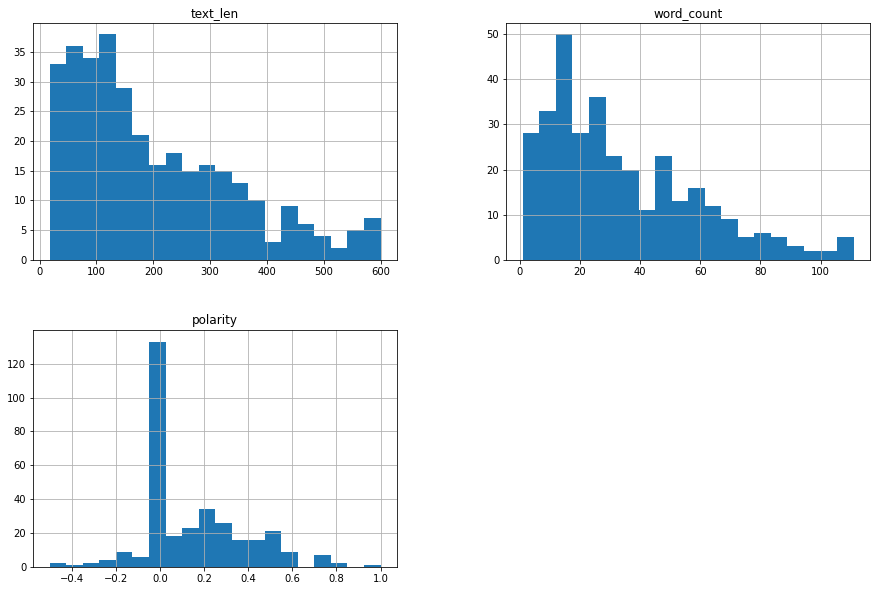

In [23]:
Comments[["text_len", "word_count", "polarity"]].hist(bins=20, figsize=(15, 10))

From the above graph we can conclude that the text length and word count are left skewed, which shows that most of the comments are having length of 30-40. From the polarity graph we can see that most of the data is neutral, which indicated that all of the comments are about some neutral topics, very few are having polarized data.

Another graph that I am making here is Wordcloud, which is a common and beautiful visualization for text data to plot the frequency of words. To create the word cloud, I combined all the texts in the review1 column to made a bid text block. Word cloud will give a basic visualization which gives the frequency of the words.

In [24]:
text = " ".join(text for text in Comments.Text1)

To make this graph I will used the combined text, and by using the wordcloud module from python. here I will ignore the stopwords in the process and only make a wordcloud of text available in the comments. 

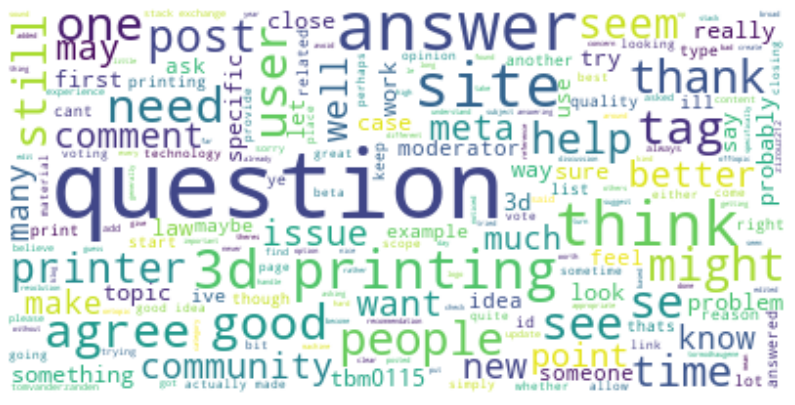

In [25]:
stopwords = set(STOPWORDS)
stopwords = stopwords.union(["ha", "thi", "now", "onli", "im", "becaus", "wa", "will", "even", "go", "realli", "didnt", "abl"])
wordcl = WordCloud(stopwords = stopwords, background_color='white', max_font_size = 50, max_words = 5000).generate(text)
plt.figure(figsize=(14, 12))
plt.imshow(wordcl, interpolation='bilinear')
plt.axis('off')
plt.show()

So, here is the wordcloud of comments text data, which shows that it is all about questions. As, stact-exchange website is completely based on a community where people ask the question about differnt topics. So, this graph clearly shows what kind of data is avilable inside dataset. 

This is common practice in text data analysis to make charts of the frequency of words. That gives a good idea about what people are talking about most in this text. First, find the frequency of each word in the text column of the dataset. Then plot the top 20 words based on the frequency.

In [26]:
def get_top_n_words(corpus, n=None):
    vec=CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(Comments['Text1'], 20)
df1 = pd.DataFrame(common_words, columns = ['Comment', 'count'])
df1.head()

,Comment,count
0,question,155
1,answer,69
2,would,56
3,think,55
4,3d,55


Above is a table which shwos the comment and the totla numbr of workds in that comment. 

Now, to plot the frequency of these word counts, I am going to use `plt.plot()` to plot the top 20 words frequency in the comments textul data. 

<AxesSubplot:title={'center':'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

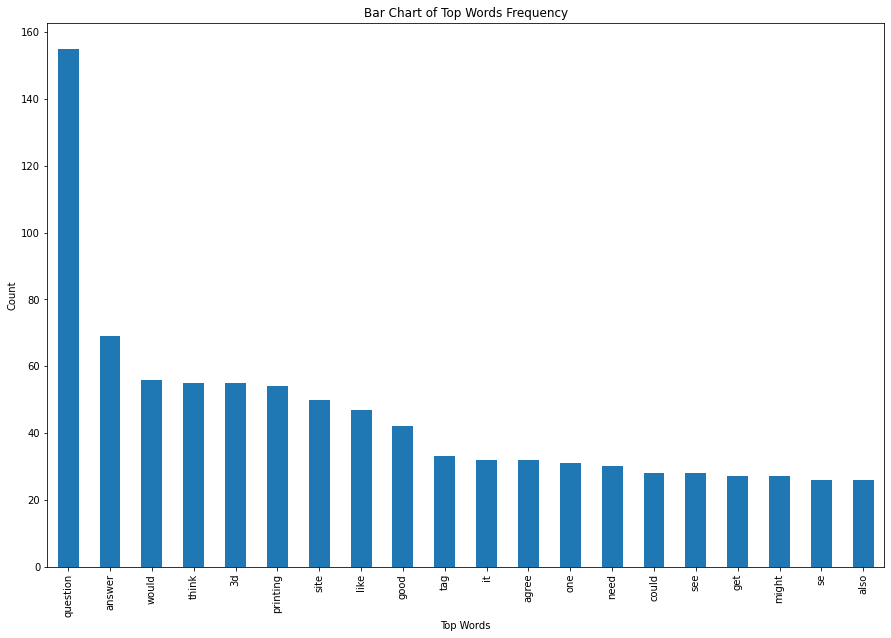

In [27]:
df1.groupby('Comment').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(15, 10),
    xlabel = "Top Words",
    ylabel = "Count",
    title = "Bar Chart of Top Words Frequency"
)

From this graph we can clearly visualize the most used word in the comments dataset. `Question` is the word that is having greated frequncy, this single word is used for about 150 times. Some other mostly used words are given in this histogram. 

These are the topmost occurring words in the reviews. But instead of just seeing one word two consecutive words or three consecutive words are more helpful. They provide some meaning. The following plot shows the topmost frequent bigrams

In [28]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words2 = get_top_n_bigram(Comments['Text1'], 30)
df2 = pd.DataFrame(common_words2, columns=['Comment', "Count"])
df2.head()

,Comment,Count
0,3d printing,43
1,good idea,9
2,stack exchange,8
3,answer question,8
4,se site,6


Now, in this dataframe we have the 2 words phrases which we will be printing to see the use case of these phrase.

<AxesSubplot:title={'center':'Bar chart of Bigrams Frequency'}, xlabel='Bigram Words', ylabel='Count'>

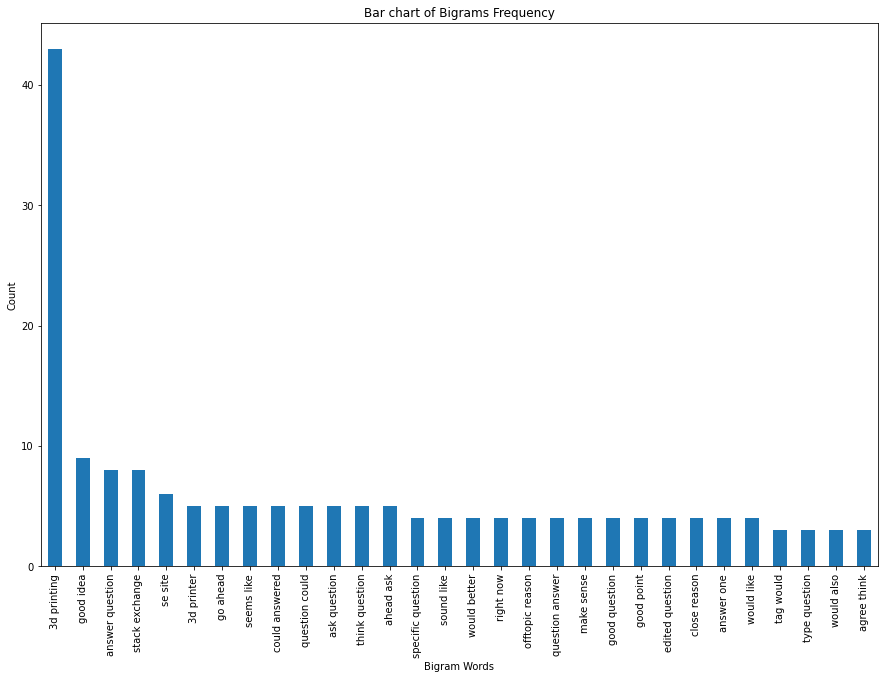

In [29]:
df2.groupby('Comment').sum()['Count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(15,10),
    xlabel = "Bigram Words",
    ylabel = "Count",
    title = "Bar chart of Bigrams Frequency"
)

So, clearly we can see this gives us a better visualization, to guess what kind of textual data is present in this dataset. so 3d printing is the clause which used for more then 40 times in this dataset, which defines that dataset talks more about 3d printing. 

Look at the bigrams. They are somewhat phrases that make more sense. The next plot is the trigrams. Maybe that will provide us some more ideas about what people are saying in the reviews.

<AxesSubplot:title={'center':'Bar chart of Trigrams Frequency'}, xlabel='Trigram Words', ylabel='Count'>

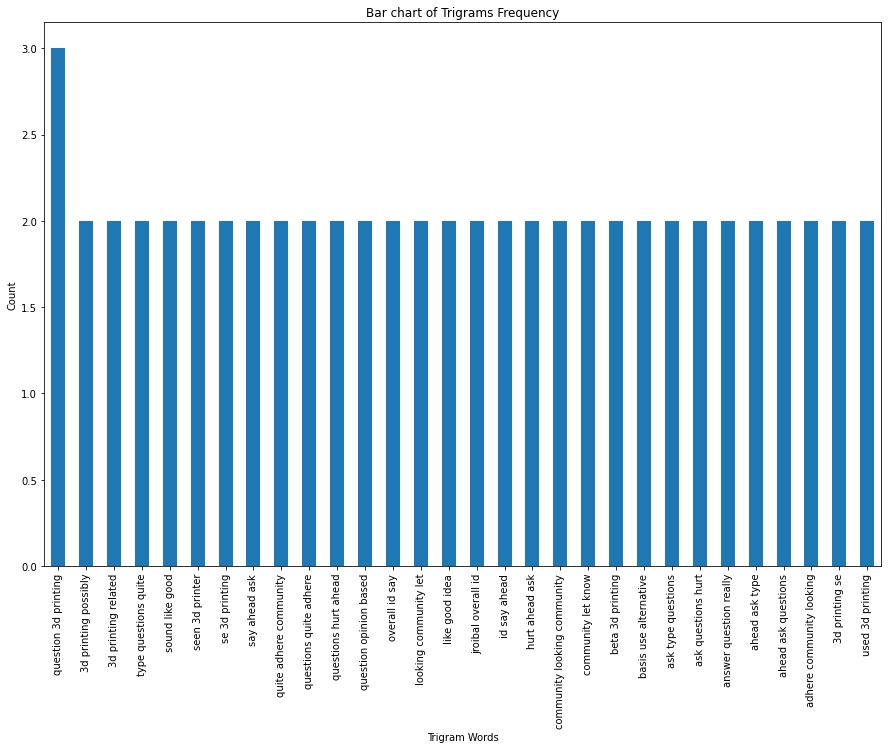

In [30]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words3 = get_top_n_trigram(Comments['Text1'], 30)
df3 = pd.DataFrame(common_words3, columns = ['Comment' , 'Count'])
df3.groupby('Comment').sum()['Count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(15,10),
    xlabel = "Trigram Words",
    ylabel = "Count",
    title = "Bar chart of Trigrams Frequency"
)

Finally we come to this trigram which clearly shows which senteces we'll find in this dataset. the first in this histogram is `question 3d printing` which is the mostly used 3 words phrase in this dataset. 

In text based data it is often good practice to find see how parts of speech is utilized in the text data, which will give us a clear shot to see what kind of words we might find in this dataset. This is a process of tagging the words with the part of speech such as nouns, pronouns, verbs, adjectives, etc. It can be done easily using TextBlob API. In this code block I will be making a bar chart which would show how the parts of speech is used in the textual data.

<AxesSubplot:title={'center':'Bar Chart of the Frequency of the Parts of Speech'}, xlabel='Part Of Speech', ylabel='Frequency'>

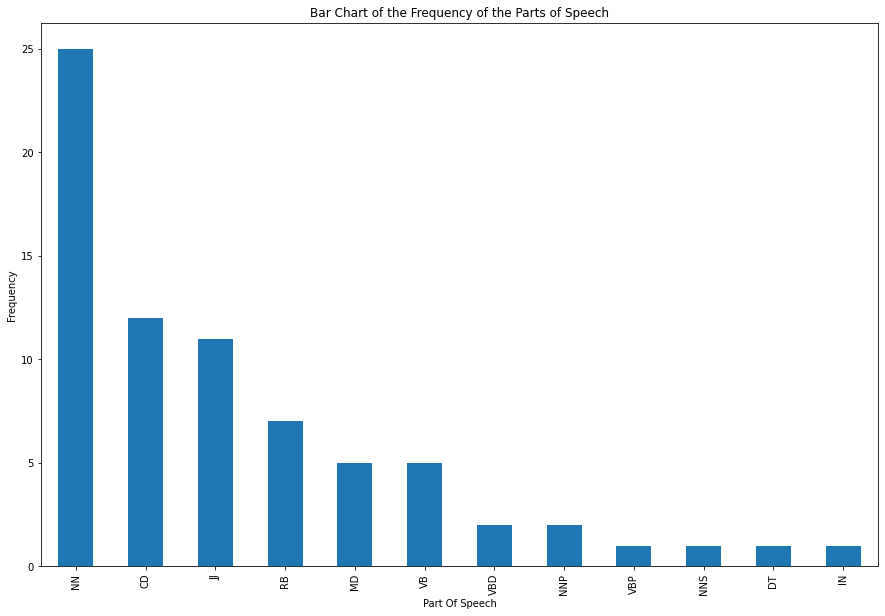

In [31]:
blob = TextBlob(str(Comments['Text1']))
pos_df = pd.DataFrame(blob.tags, columns = ['word', 'pos'])
pos_df = pos_df.pos.value_counts()[:30]
pos_df.plot(kind='bar',
            xlabel = "Part Of Speech",
           ylabel = "Frequency",
           title = "Bar Chart of the Frequency of the Parts of Speech",
           figsize=(15, 10))

So, here you see we can easily see which parts of speech words are mostly available in the dataset. 

###### Posts Dataset
From here I will be now using posts dataset to get some insights from that data. Posts dataset includes the post text, it's title, score, number of viewers, ownerid etc. I will be useing some of the columns for analysis.  

In [32]:
Posts.head()

,Unnamed: 0,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,...,CommentCount,FavoriteCount,ParentId,LastEditorUserId,LastEditDate,AcceptedAnswerId,CommunityOwnedDate,ClosedDate,OwnerDisplayName,Body1
0,0,1,1,2016-01-12T19:24:29.457,19,99.0,<p>I have been wanting to learn about 3D print...,30,2016-01-13T13:36:41.160,"What can ""newbies"" do to help the site at this...",...,1,2.0,0.0,0.0,0,0.0,0,0,0,pi wanting learn 3d printing long time really ...
1,1,2,1,2016-01-12T19:39:07.193,2,45.0,<p>There are many different printing technolog...,10,2016-01-13T00:43:12.200,Should the specification of printer technology...,...,3,0.0,0.0,0.0,0,0.0,0,0,0,pthere many different printing technologies mi...
2,2,3,2,2016-01-12T20:09:21.760,2,0.0,"<p>No, there will be many questions which are ...",16,2016-01-12T20:09:21.760,0,...,1,0.0,2.0,0.0,0,0.0,0,0,0,pno many questions general nature little actua...
3,3,4,2,2016-01-12T20:14:12.953,3,0.0,"<p>For questions where the technology matters,...",9,2016-01-12T20:14:12.953,0,...,0,0.0,2.0,0.0,0,0.0,0,0,0,pfor questions technology matters absolutelyp ...
4,4,5,1,2016-01-12T20:14:43.087,9,85.0,<p>Stack exchange isn't a good platform for pr...,16,2016-01-13T15:29:35.547,How do we handle recommendations?,...,1,0.0,0.0,0.0,0,0.0,0,0,0,pstack exchange good platform product recommen...


###### Table2
To make this table I will use the posts dataset and in it I will only be selecting title, score,viewcount, text and some other columns that I will be adding to this table. In this table I am going to add length of the body text, total number of words, and the polarity of the sentences. 

In [33]:
Posts['body_len'] = Posts['Body1'].astype(str).apply(len)
Posts['word_count'] = Posts['Body1'].apply(lambda x: len(str(x).split()))
Posts['polarity'] = Posts['Body1'].map(lambda text: TextBlob(text).sentiment.polarity)

In [34]:
Table2 = Posts[['Title','Score','ViewCount','Body1','body_len','word_count','polarity']]

In [35]:
Table2.head()

,Title,Score,ViewCount,Body1,body_len,word_count,polarity
0,"What can ""newbies"" do to help the site at this...",19,99.0,pi wanting learn 3d printing long time really ...,286,43,0.050000
1,Should the specification of printer technology...,2,45.0,pthere many different printing technologies mi...,508,71,0.050000
2,0,2,0.0,pno many questions general nature little actua...,155,23,0.135417
3,0,3,0.0,pfor questions technology matters absolutelyp ...,204,28,0.165625
4,How do we handle recommendations?,9,85.0,pstack exchange good platform product recommen...,381,56,0.083333


So, this is the table that show's the tilte of the post, it's score, it's number of views, and it's length, word_count, and polarity. 

To visualize this data I would like to make some histograms which show's us how distributed data is here. 

array([[<AxesSubplot:title={'center':'body_len'}>,
        <AxesSubplot:title={'center':'word_count'}>],
       [<AxesSubplot:title={'center':'polarity'}>,
        <AxesSubplot:title={'center':'ViewCount'}>]], dtype=object)

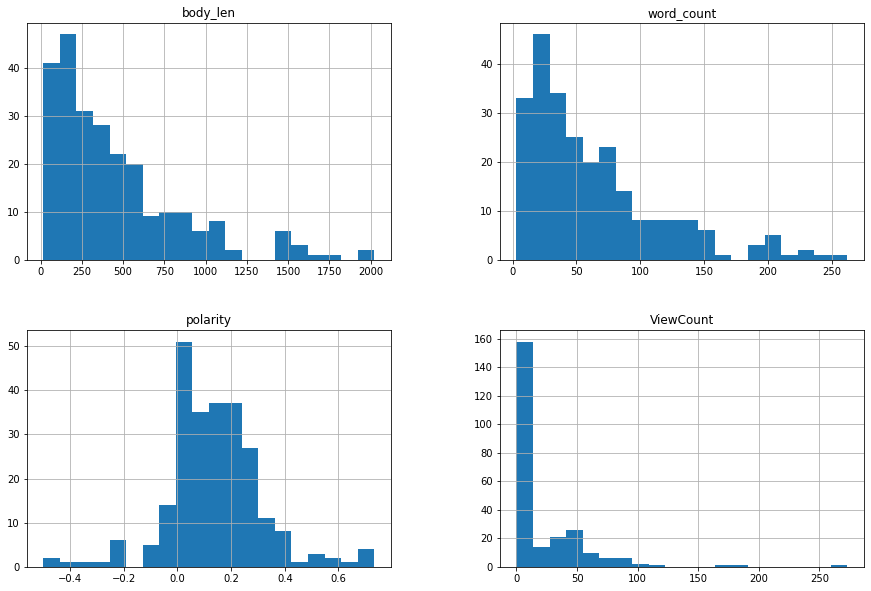

In [36]:
Posts[["body_len", "word_count", "polarity",'ViewCount']].hist(bins=20, figsize=(15, 10))

From here we see that the textual data available inside posts dataset is left skewed. If we look at the polarity map then we can see that data is mostly neutral,and some data is with positive polarity. From viewcount we can get some information that there are some posts which get more than 150 views. 

In this graph let's see if there is any relation between the polarity and the viewcounts. In this graph the main purpose is to see what kind of posts have the most views. This can be very usefull graph while the data has diversed polarity, but just to check as this data has some positive polarity text. 

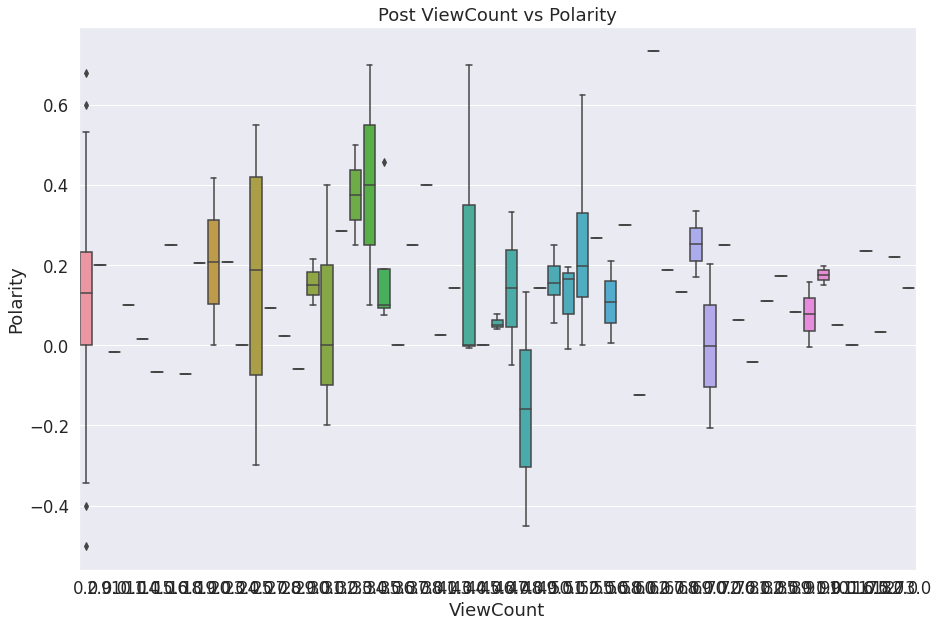

In [37]:
plt.figure(figsize = (15, 10))
sns.set_style('whitegrid')
sns.set(font_scale = 1.5)
sns.boxplot(x = 'ViewCount', y = 'polarity', data = Table2)
plt.xlabel("ViewCount")
plt.ylabel("Polarity")
plt.title("Post ViewCount vs Polarity")
plt.show()

Finally, here I am going to use Badges dataset. In this dataset I got a Name column which I will be using in the following graph. Here let's see who are the users motlsy. Or, what badge is frequently used in this dataset. 

Here, I will just make a 1 graph that is wrodcloud in which we can clearly see which badge is mostly used.

In [43]:
text1 = " ".join(text for text in Badges.Name)

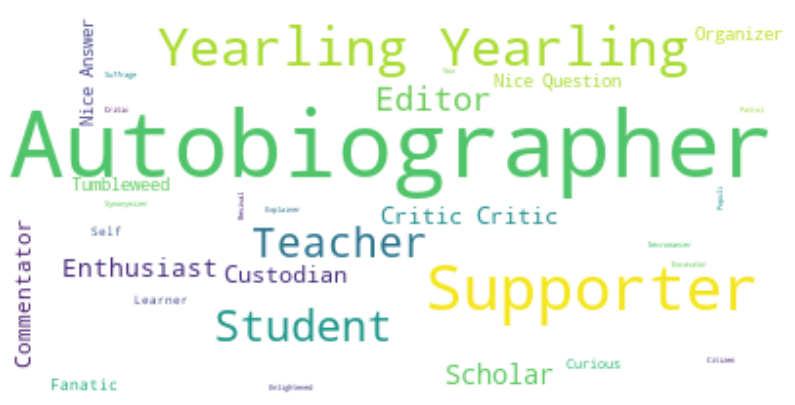

In [45]:
wordcl = WordCloud(stopwords = stopwords, background_color='white', max_font_size = 50, max_words = 5000).generate(text1)
plt.figure(figsize=(14, 12))
plt.imshow(wordcl, interpolation='bilinear')
plt.axis('off')
plt.show()

So, here you can see that `Autobiographer`  is a badge that is used frequently.

#### Conclusion
In this particular notebook, I tried to use some great ways to extract information from a piece of text. In the preprocessing section, I introduced several preprocessing techniques that are useful in machine learning as well. These all techniques may not be used for preprocessing data, here in all the analysis or machine learning.  After that, some general exploratory analysis techniques are used. There are a lot more techniques available out there, I used a few of them to get some insights from stack-exchange website data. 